In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import pandas as pd
import numpy as np
import torch.nn as nn

# Data Prep

## Create mutated sequences

In [5]:
df = pd.read_csv('../train.csv')

# get the sequence
seq = open('../sequence.fasta', 'r').read()
seq = seq.split("\n")[1]

# create each mutated sequence using the info
sequences = []
for i in df['mutant']:
    ind = int(i[1:-1])
    tmp = seq[:ind] + i[-1] + seq[ind+1:]
    sequences.append(tmp)
df['sequence'] = sequences

In [6]:
SEQ_LENGTH = len(seq)

## Prepare One_hot

In [7]:
# Define the amino acids
amino_acids = "ACDEFGHIKLMNPQRSTVWXY"  # 20 standard amino acids

# Create a dictionary to map amino acids to indices
aa_dict = {aa: idx for idx, aa in enumerate(amino_acids)}

# Function to convert sequence to one-hot encoding
def seq_to_one_hot(sequence):
    one_hot = np.zeros((len(sequence), len(amino_acids)))
    for i, aa in enumerate(sequence):
        if aa in aa_dict:
            one_hot[i, aa_dict[aa]] = 1
    return one_hot

In [8]:
# Convert the sequences into one-hot encodings
df['one_hot_sequence'] = df['sequence'].apply(lambda seq: seq_to_one_hot(seq).tolist())


In [9]:
df.head()

,mutant,DMS_score,sequence,one_hot_sequence
0,M0Y,0.2730,YVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,M0W,0.2857,WVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,M0V,0.2153,VVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,M0T,0.3122,TVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,M0S,0.2180,SVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## Prepare K_validation

In [10]:
# Prepare the data
def get_data(df):
    X = np.array(df['one_hot_sequence'].tolist())  # One-hot encoded sequences
    X = X.transpose(0, 2, 1) # shape expected (N, C_in, L)
    y = np.array(df['DMS_score'].tolist())  # DMS scores (target)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# CNN Model

## Model Def

In [13]:
# Define the CNN model for input shape (batch_size, 656, 21)
class AminoAcidCNN(nn.Module):
    def __init__(self, seq_length, num_amino_acids):
        super(AminoAcidCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=num_amino_acids, out_channels=32, kernel_size=3, padding=1)  # 32 filters
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # 64 filters
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # 128 filters
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Fully connected layers
        # After applying 3 convolution layers and pooling, the sequence length will be reduced by a factor of 8
        self.fc1 = nn.Linear(128 * (seq_length // 8), 64)  # Adjust the output dimension based on the input length
        self.fc2 = nn.Linear(64, 1)  # Single output for fitness score

    def forward(self, x):
        # Forward pass through convolutional layers
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        # Flatten the tensor for the fully connected layers
        x = x.view(x.size(0), -1)  # Flatten

        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer (fitness score)
        return x

# Example usage:
num_amino_acids = len(amino_acids)  # For standard amino acids (A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y)

# Create the model
cnn_model = AminoAcidCNN(SEQ_LENGTH, num_amino_acids)

# Print the model summary (optional)
print(cnn_model)

# Example input: batch size of 32, sequence length 100, and 20


AminoAcidCNN(
  (conv1): Conv1d(21, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10496, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


## Training

In [16]:
from sklearn.model_selection import KFold
import torch
K = 5
EPOCHS = 100
BATCH_SIZE = 32

In [17]:
X, y = get_data(df)
num_samples, seq_length, num_amino_acids = X.shape

kfold = KFold(n_splits=K, shuffle=True, random_state=42)

In [18]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np

# Suppose you have defined:
# - kfold (the KFold or StratifiedKFold instance)
# - AminoAcidCNN (your model class)
# - X, y (your data and targets)
# - EPOCHS, BATCH_SIZE, etc.

fold_train_losses = []  # Will store a list of training-loss-per-epoch for each fold
fold_val_losses = []    # Will store the final validation loss for each fold

for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
    print(f"Training fold {fold + 1}/{kfold.n_splits}")
    
    # Split the data into training and validation sets
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Initialize the model
    model = AminoAcidCNN(SEQ_LENGTH, len(amino_acids))
    
    # Define the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    criterion = nn.MSELoss()  # Mean Squared Error for regression

    # Keep track of losses for each epoch
    train_losses_this_fold = []

    # Training the model
    for epoch in range(EPOCHS):
        model.train()
        
        # We’ll accumulate loss over batches and then compute the average
        running_loss = 0.0
        num_batches = 0
        
        for i in range(0, len(X_train), BATCH_SIZE):
            X_batch = X_train[i:i + BATCH_SIZE]
            y_batch = y_train[i:i + BATCH_SIZE]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.view(-1, 1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            num_batches += 1

        epoch_loss = running_loss / num_batches
        train_losses_this_fold.append(epoch_loss)

        # Print training loss for the epoch
        print(f"Fold {fold+1}, Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}")
    
    # Evaluate on validation set after full training for this fold
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val.view(-1, 1))
    
    print(f"Validation Loss for fold {fold + 1}: {val_loss.item():.4f}\n")

    # Store the training losses for this fold
    fold_train_losses.append(train_losses_this_fold)
    # Store the final validation loss for this fold
    fold_val_losses.append(val_loss.item())

# =========================
# AFTER ALL FOLDS COMPLETE
# =========================
avg_val_loss = np.mean(fold_val_losses)
print(f"Average Validation Loss across {kfold.n_splits} folds: {avg_val_loss:.4f}")


Training fold 1/5
Fold 1, Epoch [1/100], Loss: 0.0533
Fold 1, Epoch [2/100], Loss: 0.0449
Fold 1, Epoch [3/100], Loss: 0.0451
Fold 1, Epoch [4/100], Loss: 0.0438
Fold 1, Epoch [5/100], Loss: 0.0434
Fold 1, Epoch [6/100], Loss: 0.0434
Fold 1, Epoch [7/100], Loss: 0.0432
Fold 1, Epoch [8/100], Loss: 0.0431
Fold 1, Epoch [9/100], Loss: 0.0430
Fold 1, Epoch [10/100], Loss: 0.0429
Fold 1, Epoch [11/100], Loss: 0.0428
Fold 1, Epoch [12/100], Loss: 0.0428
Fold 1, Epoch [13/100], Loss: 0.0428
Fold 1, Epoch [14/100], Loss: 0.0427
Fold 1, Epoch [15/100], Loss: 0.0427
Fold 1, Epoch [16/100], Loss: 0.0427
Fold 1, Epoch [17/100], Loss: 0.0427
Fold 1, Epoch [18/100], Loss: 0.0426
Fold 1, Epoch [19/100], Loss: 0.0426
Fold 1, Epoch [20/100], Loss: 0.0426
Fold 1, Epoch [21/100], Loss: 0.0426
Fold 1, Epoch [22/100], Loss: 0.0426
Fold 1, Epoch [23/100], Loss: 0.0427
Fold 1, Epoch [24/100], Loss: 0.0427
Fold 1, Epoch [25/100], Loss: 0.0428
Fold 1, Epoch [26/100], Loss: 0.0426
Fold 1, Epoch [27/100], Loss:

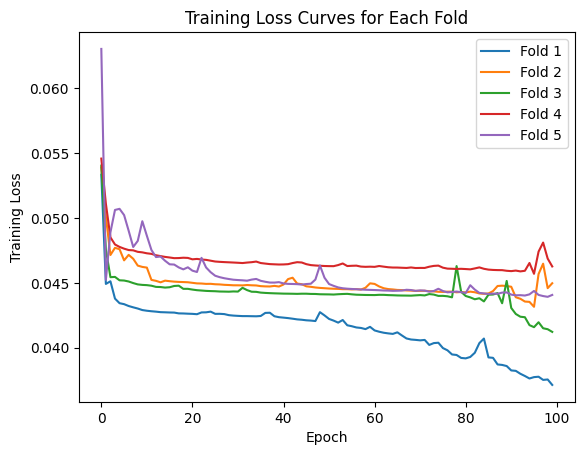

In [19]:
import matplotlib.pyplot as plt

plt.figure()
for fold_idx, train_loss_list in enumerate(fold_train_losses, start=1):
    plt.plot(train_loss_list, label=f'Fold {fold_idx}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curves for Each Fold')
plt.legend()
plt.show()


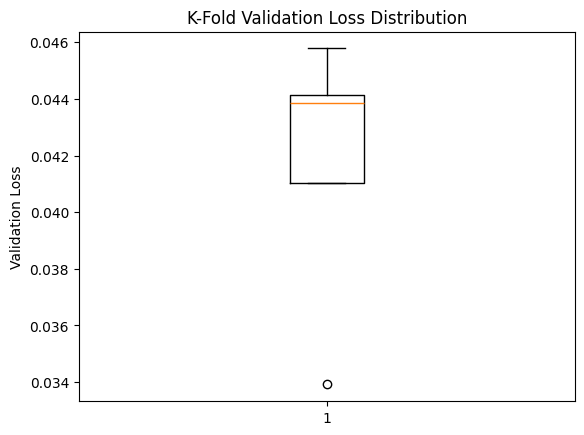

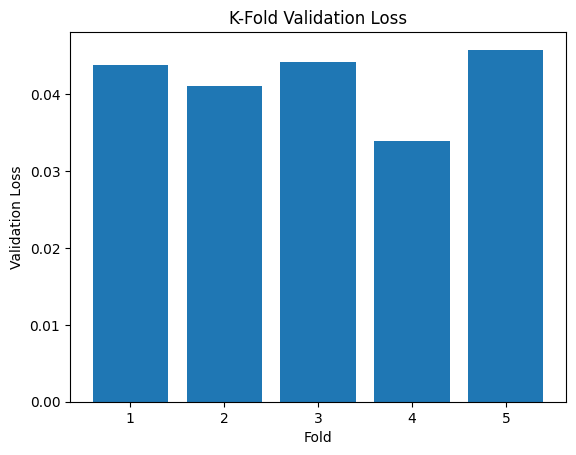

In [21]:
# Box plot
plt.figure()
plt.boxplot(fold_val_losses)
plt.ylabel('Validation Loss')
plt.title('K-Fold Validation Loss Distribution')
plt.show()

# # OR a simple bar chart
plt.figure()
plt.bar(range(1, len(fold_val_losses)+1), fold_val_losses)
plt.xlabel('Fold')
plt.ylabel('Validation Loss')
plt.title('K-Fold Validation Loss')
plt.show()


## Test Performance

In [23]:
from scipy.stats import spearmanr

def compute_predictions_and_spearman(df, model):
    # Get the data from the dataframe
    X, y = get_data(df)

    # Ensure the model is in evaluation mode
    model.eval()

    # Compute predictions
    with torch.no_grad():
        predicted_dms_scores = model(X).squeeze().numpy()  # Flatten to 1D array

    # Compute Spearman correlation
    correlation, _ = spearmanr(predicted_dms_scores, y.numpy())  # Compute Spearman correlation between actual and predicted DMS scores

    return predicted_dms_scores, correlation

_, correlation = compute_predictions_and_spearman(df, model)
correlation

0.4487271205802045

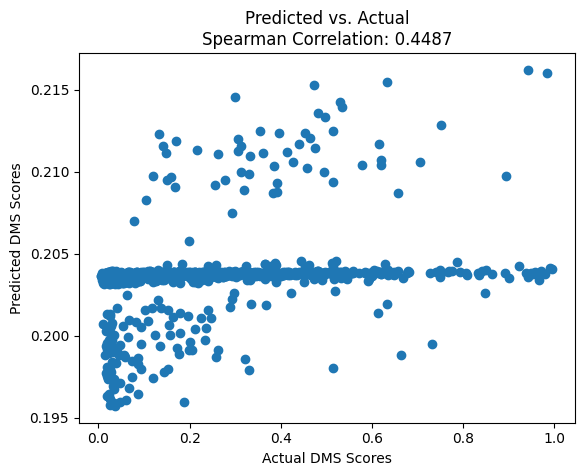

In [24]:
import matplotlib.pyplot as plt

def visualize_predictions(df, model):
    # Get predictions and correlation
    predicted_dms_scores, correlation = compute_predictions_and_spearman(df, model)

    # Retrieve actual labels (ground-truth DMS scores)
    #   If get_data(df) returns (X, y), then y is what we need here.
    _, y = get_data(df)
    
    # Convert to NumPy arrays if not already
    actual_dms_scores = y.numpy().squeeze()  # Flatten to 1D just in case

    # Create a scatter plot of actual vs. predicted
    plt.figure()
    plt.scatter(actual_dms_scores, predicted_dms_scores)
    plt.xlabel("Actual DMS Scores")
    plt.ylabel("Predicted DMS Scores")
    plt.title(f"Predicted vs. Actual\nSpearman Correlation: {correlation:.4f}")
    plt.show()

# Usage:
visualize_predictions(df, model)
